In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM
import copy


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [3]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [4]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [5]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [8]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### Compute binary classification accuracy for different sets of trials
Easy = furthest rows from boundary

Medium = closer rows to boundary, but still in main grid


In [9]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_easytrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_medtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # use correct trials only here
        correct = np.array(l['subject_correct'])
        
        # loop over "axes" - which boundary to compute accuracy for
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            coord_actual = pt_labs[:,ii].round(2)
           
            # easy is the furthest from bound
            # medium is second furthest
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)
            is_hard = dist_from_center<0.8
            is_easy = (dist_from_center==2.4) & is_main_grid
            is_medium = (dist_from_center==0.8) & is_main_grid
           
            # loop over ROIs
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                coords_pred = grid_pts[pred]
                categ_pred = grid_utils.get_categ(coords_pred, ii+1)
                
                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                
                
                inds = is_main_grid & correct
                
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_allmaintrials[si,ri,ti,ii] = d;
                
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_easy & correct
                                                          
                conf_easytrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_easytrials[si,ri,ti,ii] = d;
                
                acc_easytrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_medium & correct
                                                      
                conf_medtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_medtrials[si,ri,ti,ii] = d;
                
                acc_medtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                

#### Get confidence for hardest trials

For the hardest trials, the average confidence values are generated by resampling 
the center grid trials so that the distribution of stims is more even across tasks.

this is done in bootstrap_confidence.py (i saved it to disk because it takes ~10 minutes to run)

can skip to next cell if it's done already

In [30]:
import bootstrap_confidence
bootstrap_confidence.bootstrap_binary_hardtrials(n_boot_iter=1000)

0
1
2
3
4
5
6


In [33]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_bootstrap_correctonly.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_boot = b['signedconf_hardtrials_boot']
conf_hardtrials = np.mean(signedconf_hardtrials_boot, axis=4)

In [34]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

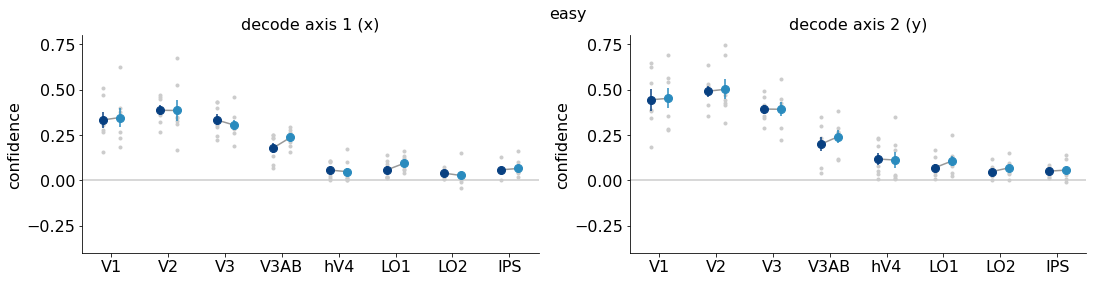

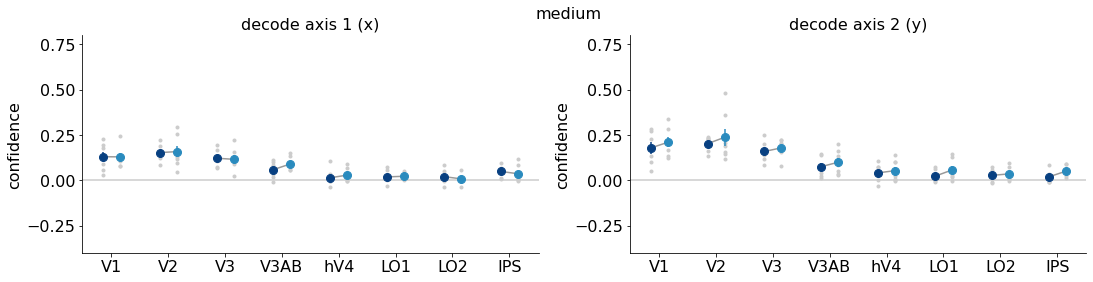

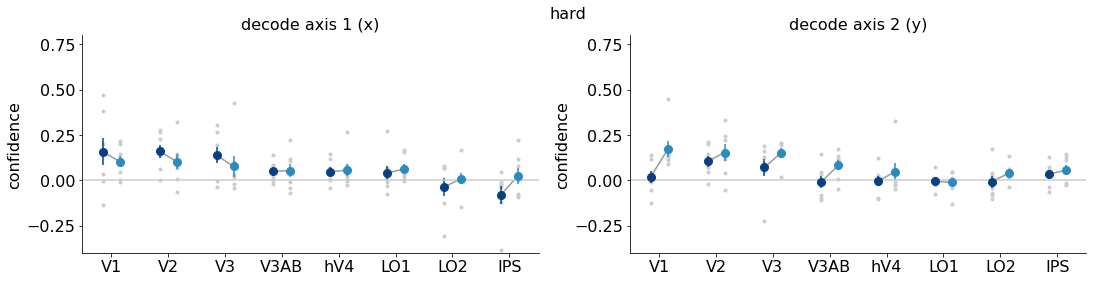

In [35]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15,2)

for rvals, name in zip([conf_easytrials, conf_medtrials, conf_hardtrials], \
                     ['easy','medium','hard']):    
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8, \
                     # markerfacecolor='none', \
                    )
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6],zorder=-5)

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.40, 0.8])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('%s'%name)
    
    figname = os.path.join(figfolder, 'multi_binary_%s.pdf'%(name))
    plt.savefig(figname)


In [20]:
for cvals, diffname in zip([conf_easytrials, conf_medtrials, conf_hardtrials], \
                        ['easy','medium','hard']):

    
    vals = copy.deepcopy(cvals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['roi','task','axis'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for confidence, %s trials'%(diffname))
    print(anova_result)



Anova for confidence, easy trials
                 F Value  Num DF  Den DF  Pr > F
roi            43.490356     7.0    42.0  0.0000
task            0.651793     1.0     6.0  0.4503
axis           22.091703     1.0     6.0  0.0033
roi:task        0.444169     7.0    42.0  0.8685
roi:axis       12.066132     7.0    42.0  0.0000
task:axis       0.646886     1.0     6.0  0.4519
roi:task:axis   0.712959     7.0    42.0  0.6613

Anova for confidence, medium trials
                 F Value  Num DF  Den DF  Pr > F
roi            24.368585     7.0    42.0  0.0000
task            3.098721     1.0     6.0  0.1288
axis           21.205794     1.0     6.0  0.0037
roi:task        0.211044     7.0    42.0  0.9810
roi:axis        6.513769     7.0    42.0  0.0000
task:axis      12.163327     1.0     6.0  0.0130
roi:task:axis   0.544780     7.0    42.0  0.7955

Anova for confidence, hard trials
                F Value  Num DF  Den DF  Pr > F
roi            4.855695     7.0    42.0  0.0004
task         

In [21]:
for cvals, diffname in zip([conf_easytrials, conf_medtrials, conf_hardtrials], \
                        ['easy','medium','hard']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)
        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        print('\nAnova for confidence w/r/t %s, %s trials'%(axis_name, diffname))
        print(anova_result)



Anova for confidence w/r/t axis 1 (x), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       38.498475     7.0    42.0  0.0000
task       0.216006     1.0     6.0  0.6585
roi:task   0.712520     7.0    42.0  0.6616

Anova for confidence w/r/t axis 2 (y), easy trials
            F Value  Num DF  Den DF  Pr > F
roi       43.600532     7.0    42.0  0.0000
task       1.594126     1.0     6.0  0.2536
roi:task   0.246491     7.0    42.0  0.9706

Anova for confidence w/r/t axis 1 (x), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       18.123794     7.0    42.0  0.0000
task       0.103215     1.0     6.0  0.7589
roi:task   0.459153     7.0    42.0  0.8582

Anova for confidence w/r/t axis 2 (y), medium trials
            F Value  Num DF  Den DF  Pr > F
roi       24.931762     7.0    42.0  0.0000
task      10.216725     1.0     6.0  0.0187
roi:task   0.173503     7.0    42.0  0.9893

Anova for confidence w/r/t axis 1 (x), hard trials
           F Value  Num DF  Den 

In [29]:
for cvals, diffname in zip([conf_medtrials, conf_hardtrials], \
                        ['medium','hard']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


medium trials, axis 1 (x)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                         0.023   0.983             4
V2                        -0.178   0.848             4
V3                         0.209   0.828             4
V3AB                      -1.329   0.240             5
hV4                       -0.622   0.509             6
LO1                       -0.347   0.748             4
LO2                        0.716   0.519             4
IPS                        0.986   0.333             5

medium trials, axis 2 (y)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -2.158   0.109             5
V2                        -0.788   0.486             4
V3                        -0.773   0.487             4
V3AB                      -1.083   0.336             4
hV4                       -0.964   0.426             4
LO1                       -1.789   0.094             5
LO2                       -0.392   0.722             4
IPS        